Se leen los archivos recibidos. <br>
Se crea la columna category_price que contendrá el valor 0 para las propiedades con un precio menor a 1000 y 1 para los demas precios. <br>
Se codifica a ordinal los valores de las columnas state, region, type, laundry_options y parking_options manteniendo la correlación con el archivo de pruebas.

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

dfFull = pd.read_csv('../Datasets/dePrimero.csv')
dftest = pd.read_parquet('../proyecto_ML/test.parquet')
# crear columna de y category_price con valor 1 si es < 1000
dfFull['category_price'] = np.where(dfFull['price'] < 1000, 1, 0)

#Codificar a Ordinar las columnas region, state y type manteniendo la codificacion en test y train
concat = pd.concat([dfFull, dftest], axis=0, ignore_index=True)
# Codificar state
enc_state = LabelEncoder()
enc_state.fit(concat['state'])
dfFull['stateord'] = enc_state.transform(dfFull['state'])
dftest['stateord'] = enc_state.transform(dftest['state'])
# Codificar region
enc_region = LabelEncoder()
enc_region.fit(concat['region'])
dfFull['regionord'] = enc_region.transform(dfFull['region'])
dftest['regionord'] = enc_region.transform(dftest['region'])
# Codificar type
enc_type = LabelEncoder()
enc_type.fit(concat['type'])
dfFull['typeord'] = enc_type.transform(dfFull['type'])
dftest['typeord'] = enc_type.transform(dftest['type'])
# Codificar laundry_options
dfFull.laundry_options.replace({np.nan: None}, inplace=True) #del cvs carga nan y del parquet carga None
enc_laundry_options = LabelEncoder()
enc_laundry_options.fit(concat['laundry_options'])
dfFull['laundry_optionsord'] = enc_laundry_options.transform(dfFull['laundry_options'])
dftest['laundry_optionsord'] = enc_laundry_options.transform(dftest['laundry_options'])
# Codificar parking_options
dfFull.parking_options.replace({np.nan: None}, inplace=True) #del cvs carga nan y del parquet carga None
enc_parking_options = LabelEncoder()
enc_parking_options.fit(concat['parking_options'])
dfFull['parking_optionsord'] = enc_parking_options.transform(dfFull['parking_options'])
dftest['parking_optionsord'] = enc_parking_options.transform(dftest['parking_options'])



Se incluye un Heatmap para tener una mejor visuzlisación de las columnas que se seleccionarán para el modelo.

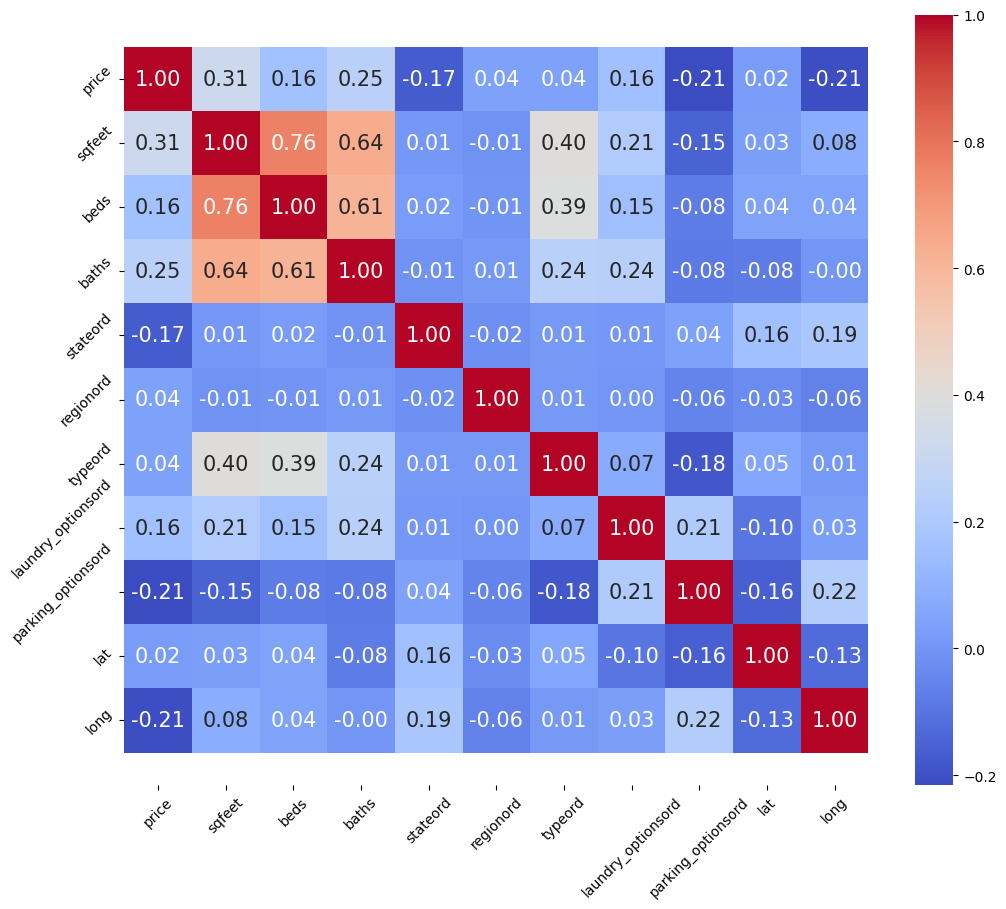

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_corre_heatmap(corr):
    '''
    Definimos una función para ayudarnos a graficar un heatmap de correlación
    '''
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, cbar = True,  square = False, annot=True, fmt= '.2f'
                ,annot_kws={'size': 15},cmap= 'coolwarm')
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 45)
    # Arreglamos un pequeño problema de visualización
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()
dfheatmap2 = dfFull[['price', 'sqfeet', 'beds', 'baths','stateord','regionord','typeord','laundry_optionsord','parking_optionsord','lat','long']]
#dfheatmap = df_filtered
corr = dfheatmap2.corr(numeric_only=True)
plot_corre_heatmap(corr)

Se crean las variables X e y del archivo de entrenamiento con las columnas seleccionadas y se crea otro dataframe con las mismas columnas en base al archivo de pruebas.
Se reemplazan los valores nulos de las coordenadas con el promedio de las coordenadas de las otras columnas.

In [18]:
xtest = dftest[['sqfeet', 'beds', 'baths','stateord','regionord','typeord','laundry_optionsord','parking_optionsord','lat','long']]
X = dfFull[['sqfeet', 'beds', 'baths','stateord','regionord','typeord','laundry_optionsord','parking_optionsord','lat','long']]
y = dfFull['category_price']
X['lat'].fillna(37.4937,inplace=True)
X['long'].fillna(-93.3605,inplace=True)
xtest['lat'].fillna(37.2255,inplace=True)
xtest['long'].fillna(-92.6575,inplace=True)

C:\Users\Nahuel\AppData\Local\Temp\ipykernel_14464\502931783.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['lat'].fillna(37.4937,inplace=True)
C:\Users\Nahuel\AppData\Local\Temp\ipykernel_14464\502931783.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['long'].fillna(-93.3605,inplace=True)
C:\Users\Nahuel\AppData\Local\Temp\ipykernel_14464\502931783.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtest['lat'].fillna(37

Generamos les resultados del arbol de desicion con multiples profundidades y lo graficamos para tener una mejor desición sobre la complejidad que debería tener el modelo.

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from IPython.display import clear_output
import matplotlib.pyplot as plt

tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,30,1)
i = 0
i_max = len(profundidades)
for profundidad in profundidades:
    i = i + 1
    clf = DecisionTreeClassifier(max_depth=profundidad)
    tree_scores = cross_validate(clf, X, y, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())
    
    clear_output(wait=True)
    print('Completado: ' + str(round(i / i_max * 100, 2)) + '%')

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

Completado: 100.0%


Graficamos los múltiples resultaodos.

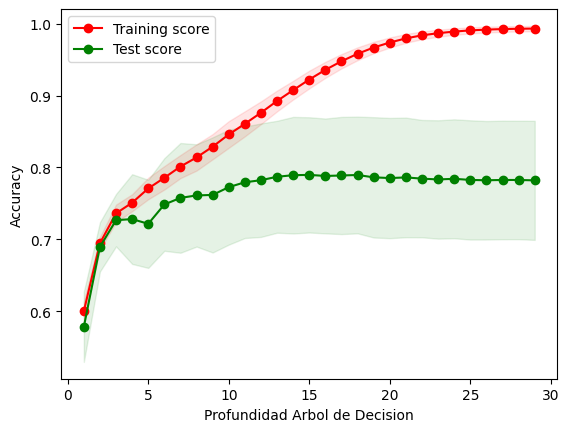

In [20]:
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

En base a los resultados obtenidos seleccionamos la profundidad y ejecutamos el modelo nuevamente.

In [21]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

arbol = DecisionTreeClassifier(max_depth = 30)

arbol.fit(X_train, y_train)

# Predecimos sobre nuestro set de entrenamieto
y_train_pred = arbol.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = arbol.predict(X_test)

# Comaparamos con las etiquetas reales
print('Porcentaje de aciertos sobre el conjunto de Entrenamiento:', accuracy_score(y_train_pred,y_train))
print('Porcentaje de aciertos sobre el conjunto de Evaluación:', accuracy_score(y_test_pred,y_test))

Porcentaje de aciertos sobre el conjunto de Entrenamiento: 0.9925008790673772
Porcentaje de aciertos sobre el conjunto de Evaluación: 0.9006137679673077


Obtenemos la predicción.

In [59]:
ytestpred = arbol.predict(xtest)
ytestpred

array([0, 0, 0, ..., 0, 1, 0])

Generamos el archivo con los resultados para enviar.

In [60]:
dfpred = pd.DataFrame({'pred': ytestpred})
dfpred.to_csv('../Datasets/naguieta.csv', index=False)